<a href="https://colab.research.google.com/github/delibae/health_care_pr/blob/pr2%2Fbhj/medicine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Proprecessing

In [1]:
import pandas as pd
import numpy as np

# ML
import torch
import torchvision

import torchvision.transforms as transforms
from sklearn.model_selection import StratifiedKFold
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split


torch.manual_seed(123)

# Create DataLoader

## load npy

In [2]:
root_path = '/content/drive/MyDrive/data/medicine/'

image_data_n = np.load(root_path + 'ImageData.npy')
dl_idx  = np.load(root_path + 'dl_idx.npy')
dl_name = np.load(root_path + 'dl_name.npy')

In [3]:
print(image_data_n.shape)
print(dl_idx.shape)
print(dl_name.shape)

(9612, 128, 128, 3)
(9612,)
(9612,)


## define get_img(cv2)

In [4]:
import cv2

def get_img_list(series) :

    
    reshaped_image_list = []

    for file_name in series :
        image_path = file_name
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)

        image = cv2.resize(image, dsize=(100, 100), interpolation=cv2.INTER_AREA)

        reshaped_image = image.reshape(3,100,100) #reshape
        reshaped_image_list.append(reshaped_image)
        
    return reshaped_image_list

## define get_transform(normalize)

In [5]:
def get_transform():

    t = list()
    t.append(transforms.ToTensor())

    # t.append(transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)))
    
    return transforms.Compose(t)

In [6]:
test_inp = np.random.rand(128,128,3)

test_trans = get_transform()

test_out = test_trans(test_inp)

## define dataset

## define dataset 2 (local load version)

In [7]:
class CustomDataset(Dataset):
    def __init__(self, img_list, label=None):
        self.transform = transforms.Compose([
                      transforms.ToTensor(),
    # -1 ~ 1 사이의 범위를 가지도록 정규화
                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        self.img_list = img_list
        self.label = label
        self.transformed_img_list = list(map(self.transform, self.img_list))
        print(self.transformed_img_list)
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, i):
        
        x_data = self.transformed_img_list[i]

        return x_data, torch.tensor(self.label[i],dtype = torch.long)

## one-hot encoding and make label list

In [8]:
label_name = pd.DataFrame(dl_idx,columns = ['dl_idx'])
label_name['dl_name'] = dl_name
label_list = label_name['dl_idx'].unique().tolist()
print(label_list)

def add(valid):
  index = label_list.index(valid)
  return index

label_name['label'] = label_name.apply(lambda row : add(row['dl_idx']), axis = 1)
print(label_name)


label = label_name['label'].tolist()
print(len(label))

['38883', '38889', '38895', '38909', '38911', '38912', '38913', '38926', '38928', '38953', '38957', '38958', '38961', '38966', '38969', '39020', '39035', '39046', '39103', '39107', '39122', '39135', '39145', '39146']
     dl_idx        dl_name  label
0     38883          에피나레정      0
1     38883          에피나레정      0
2     38883          에피나레정      0
3     38883          에피나레정      0
4     38883          에피나레정      0
...     ...            ...    ...
9607  39146  듀카브정30/10밀리그램     23
9608  39146  듀카브정30/10밀리그램     23
9609  39146  듀카브정30/10밀리그램     23
9610  39146  듀카브정30/10밀리그램     23
9611  39146  듀카브정30/10밀리그램     23

[9612 rows x 3 columns]
9612


In [9]:
print(len(label_list))

24


In [10]:
classes = label_list

## create dataset test

In [11]:
image_data_l = []

for i in image_data_n:
  image_data_l.append(i.reshape(128,128,3))

In [12]:
print(image_data_l[0].shape)

(128, 128, 3)


In [13]:
test_dataset  = CustomDataset(img_list = image_data_l, label = label)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [14]:
del test_dataset

## for local save image load

In [15]:
import pickle
import gzip

# to define
file_path_l = []

data = get_img_list(file_path_l)

with gzip.open('ImageFile.pickle', 'wb') as f:
    pickle.dump(data, f)

## define dataloader

In [16]:
import math

def get_dataloader(x, y):
    # img_list = get_img_list(x)
    dataset = CustomDataset(img_list=x, label=y)


    dataset_size = len(dataset)
    train_size = int(dataset_size * 0.8)
    validation_size = int(dataset_size * 0.1)
    test_size = dataset_size - train_size - validation_size

    train_dataset, validation_dataset, test_dataset = random_split(dataset, [train_size, validation_size, test_size])

    train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size)
    validation_dataloader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=batch_size)
    test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size)


    return train_dataloader, validation_dataloader, test_dataloader

## create dataloader!

In [24]:
batch_size = 64

train_dataloader, validation_dataloader, test_dataloader  = get_dataloader(image_data_l, label)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



# Simple CNN Model

In [19]:
import torch
import torchvision
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from sklearn.model_selection import StratifiedKFold
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## model structure

In [20]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=20, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(in_channels=20, out_channels=50, kernel_size=5, stride=1)
        self.fc1 = nn.Linear(29 * 29 * 50, 500)
        self.fc2 = nn.Linear(500, 24)

    def forward(self, x):
        # print(x.shape)
        x = F.relu(self.conv1(x))
        # print(x.shape)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        # print(x.shape)       
        x = F.relu(self.conv2(x))
        # print(x.shape)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        # print(x.shape)
        x = x.view(-1, 50*29*29)
        # print(x.shape)
        x = F.relu(self.fc1(x))
        # print(x.shape)
        x = self.fc2(x)
        # print(x.shape)
        return x
  
# test_moel = CNN()
# inp = torch.randn(2,3,128,128)
# test_moel(inp)

## device

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## create model(loss function / optimizer)

In [50]:
model = CNN().to(device)

model.train()
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001)

## Early Stopping

In [48]:
class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint저장 경로
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''validation loss가 감소하면 모델을 저장한다.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [49]:
early_stopping = EarlyStopping()

# Train

## start train

In [51]:
loss_l = []
validloss_l = []
epoch_num = 100

for epoch in range(epoch_num):
  for index, (data, target) in enumerate(train_dataloader):
    data = data.to(device)
    target = target.to(device)
    optimizer.zero_grad()  # 기울기 초기화
    output = model(data)
    loss = criterion(output, target)
    loss.backward()  # 역전파
    optimizer.step()

  for   index, (data, target) in enumerate(validation_dataloader):
    data = data.to(device)
    target = target.to(device)
    output = model(data)
    valid_loss = criterion(output,target)

  early_stopping(valid_loss, model)
  if early_stopping.early_stop:
    print("Early stopping")
    break
  print(f"loss of {epoch} epoch, {loss.item():.3f} / valid loss: {valid_loss:.3f}")
  loss_l.append(loss.item())
  validloss_l.append(valid_loss.item())


loss of 0 epoch, 3.109 / valid loss: 3.200
EarlyStopping counter: 1 out of 7
loss of 1 epoch, 3.095 / valid loss: 3.318
EarlyStopping counter: 2 out of 7
loss of 2 epoch, 3.021 / valid loss: 3.225
loss of 3 epoch, 2.962 / valid loss: 3.156
loss of 4 epoch, 2.898 / valid loss: 3.096
loss of 5 epoch, 2.808 / valid loss: 3.028
loss of 6 epoch, 2.701 / valid loss: 2.933
loss of 7 epoch, 2.570 / valid loss: 2.799
loss of 8 epoch, 2.396 / valid loss: 2.624
loss of 9 epoch, 2.170 / valid loss: 2.413
loss of 10 epoch, 1.915 / valid loss: 2.178
loss of 11 epoch, 1.665 / valid loss: 1.921
loss of 12 epoch, 1.446 / valid loss: 1.672
loss of 13 epoch, 1.271 / valid loss: 1.432
loss of 14 epoch, 1.128 / valid loss: 1.199
loss of 15 epoch, 1.005 / valid loss: 0.999
loss of 16 epoch, 0.909 / valid loss: 0.855
loss of 17 epoch, 0.830 / valid loss: 0.718
loss of 18 epoch, 0.768 / valid loss: 0.616
loss of 19 epoch, 0.716 / valid loss: 0.521
loss of 20 epoch, 0.675 / valid loss: 0.451
loss of 21 epoch, 

## plot loss

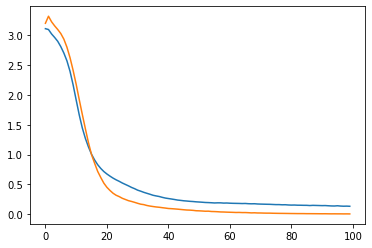

In [52]:
import matplotlib.pyplot as plt

plt.plot(loss_l, label = "train loss")
plt.plot(validloss_l, label = "valid loss")

# Model Analysis

## Confusion Matrix

In [53]:
model.eval()
model.cpu()

CNN(
  (conv1): Conv2d(3, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=42050, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=24, bias=True)
)

In [54]:
y_pred = []
y_true = []

# iterate over test data
for index, (inputs, labels) in enumerate(test_dataloader):
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

In [44]:
print(label_list)

['38883', '38889', '38895', '38909', '38911', '38912', '38913', '38926', '38928', '38953', '38957', '38958', '38961', '38966', '38969', '39020', '39035', '39046', '39103', '39107', '39122', '39135', '39145', '39146']


In [55]:
classes = label_list

In [56]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

<function matplotlib.pyplot.show(*args, **kw)>

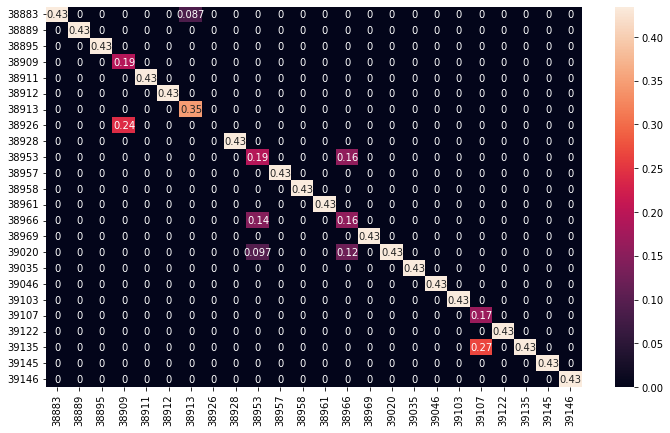

In [57]:
cf_matrix = confusion_matrix(y_true, y_pred, normalize = 'pred')
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10,index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True)
plt.show

# VGG Model(fine tuning pretrained model on torchhub)

## model structure

In [60]:
# class VGG(nn.Module):
#     def __init__(self):
#         super(VGG, self).__init__()
#         self.conv = nn.Sequential(

#             nn.Conv2d(3,64,3, padding=1),nn.LeakyReLU(0.2),
#             nn.Conv2d(64, 64, 3, padding=1),nn.LeakyReLU(0.2),
#             nn.MaxPool2d(2, 2),

#             nn.Conv2d(64, 128, 3, padding=1),nn.LeakyReLU(0.2),
#             nn.Conv2d(128, 128, 3, padding=1),nn.LeakyReLU(0.2),
#             nn.MaxPool2d(2, 2),

#             nn.Conv2d(128, 256, 3, padding=1),nn.LeakyReLU(0.2),
#             nn.Conv2d(256, 256, 3, padding=1),nn.LeakyReLU(0.2),
#             nn.Conv2d(256, 256, 3, padding=1),nn.LeakyReLU(0.2),
#             nn.MaxPool2d(2, 2),

#             nn.Conv2d(256, 512, 3, padding=1),nn.LeakyReLU(0.2),
#             nn.Conv2d(512, 512, 3, padding=1),nn.LeakyReLU(0.2),
#             nn.Conv2d(512, 512, 3, padding=1),nn.LeakyReLU(0.2),
#             nn.MaxPool2d(2, 2),

#             nn.Conv2d(512, 512, 3, padding=1),nn.LeakyReLU(0.2),
#             nn.Conv2d(512, 512, 3, padding=1),nn.LeakyReLU(0.2),
#             nn.Conv2d(512, 512, 3, padding=1),nn.LeakyReLU(0.2),
#             nn.MaxPool2d(2, 2)
#         )
#         #512 4 4
#         self.avg_pool = nn.AvgPool2d(4)
#         #512 1 1
#         self.classifier = nn.Linear(512, 24)
#         """
#         self.fc1 = nn.Linear(512*2*2,4096)
#         self.fc2 = nn.Linear(4096,4096)
#         self.fc3 = nn.Linear(4096,10)
#         """

#     def forward(self, x):
#         # print(x.shape)
#         features = self.conv(x)
#         # print(x.shape)
#         x = self.avg_pool(features)
#         # print(x.shape)
#         #print(avg_pool.size())
#         x = x.view(features.size(0), -1)
#         # print(x.shape)
#         #print(flatten.size())
#         x = self.classifier(x)
#         # print(x.shape)
#         #x = self.softmax(x)
#         return x



## device

## create model / loss function / optimizer

In [73]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg11', pretrained=True)
model.to(device)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [74]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [75]:
model.train()
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001)

## Early Stopping

In [76]:
early_stopping_2 = EarlyStopping()

# Train

## start train

In [77]:
loss_l = []
validloss_l = []
epoch_num = 100

for epoch in range(epoch_num):
  for index, (data, target) in enumerate(train_dataloader):
    data = data.to(device)
    target = target.to(device)
    optimizer.zero_grad()  # 기울기 초기화
    output = model(data)
    loss = criterion(output, target)
    loss.backward()  # 역전파
    optimizer.step()

  for   index, (data, target) in enumerate(validation_dataloader):
    data = data.to(device)
    target = target.to(device)
    output = model(data)
    valid_loss = criterion(output,target)
  early_stopping_2(valid_loss, model)
  if early_stopping_2.early_stop:
    print("Early stopping")
    break
  print(f"loss of {epoch} epoch, {loss.item():.3f} / valid loss: {valid_loss:.3f}")
  loss_l.append(loss.item())
  validloss_l.append(valid_loss.item())


loss of 0 epoch, 1.425 / valid loss: 1.443
EarlyStopping counter: 1 out of 7
loss of 1 epoch, 0.860 / valid loss: 1.954
loss of 2 epoch, 0.640 / valid loss: 0.154
loss of 3 epoch, 0.312 / valid loss: 0.087
EarlyStopping counter: 1 out of 7
loss of 4 epoch, 0.359 / valid loss: 0.237
loss of 5 epoch, 0.080 / valid loss: 0.052
loss of 6 epoch, 0.020 / valid loss: 0.011
EarlyStopping counter: 1 out of 7
loss of 7 epoch, 0.095 / valid loss: 0.014
loss of 8 epoch, 0.014 / valid loss: 0.009
loss of 9 epoch, 0.056 / valid loss: 0.000
EarlyStopping counter: 1 out of 7
loss of 10 epoch, 0.163 / valid loss: 0.047
EarlyStopping counter: 2 out of 7
loss of 11 epoch, 0.023 / valid loss: 0.001
EarlyStopping counter: 3 out of 7
loss of 12 epoch, 0.019 / valid loss: 0.010
EarlyStopping counter: 4 out of 7
loss of 13 epoch, 0.032 / valid loss: 0.005
EarlyStopping counter: 5 out of 7
loss of 14 epoch, 0.005 / valid loss: 0.000
EarlyStopping counter: 6 out of 7
loss of 15 epoch, 0.088 / valid loss: 0.004


## plot loss

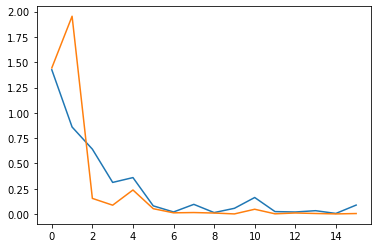

In [78]:
import matplotlib.pyplot as plt

plt.plot(loss_l, label = "train loss")
plt.plot(validloss_l, label = "valid loss")

# Moel Analysis

## Confusion Matrix

<function matplotlib.pyplot.show(*args, **kw)>

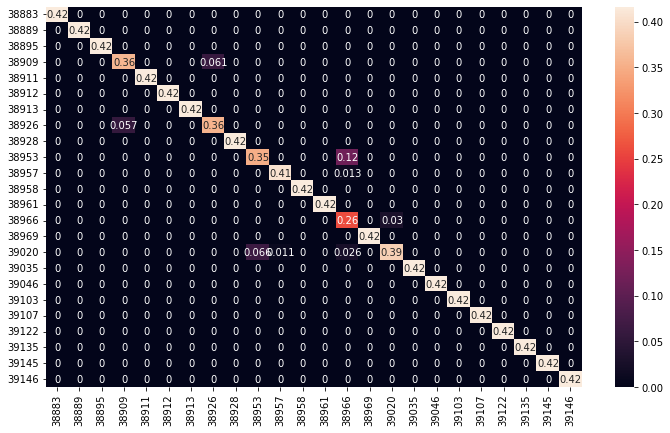

In [79]:
model.eval()
model.cpu()

y_pred = []
y_true = []

# iterate over test data
for index, (inputs, labels) in enumerate(test_dataloader):
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth


classes = label_list


from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_true, y_pred, normalize = 'pred')
df_cm_2 = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10,index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sns.heatmap(df_cm_2, annot=True)
plt.show